## Теоретическая часть


1. Ответьте на вопросы:  
В чем принципиальное отличие гибридных рекомендательных систем от коллаборативной филтьтрации?  
Приведите 2-3 примера задач, в которых необходимо использовать гибридные системы  




Коллаборативная фильтрация не учитывает информацию о контенте (характеристики пользователей, характеристики товаров). При гибридных подходе учитываются не только взаимодействия, но и индивидуальные характеристики товаров и пользователей.
Гибридный подход приходит на помощь, когда в матрице user/item мало взаимодействий, а также в тех случаях, когда нужно рекомендовать товары новому пользователю, или включить в список рекомендмаций новые товары.

2.  Прочитайте статью про поиск на hh.ru https://habr.com/ru/company/hh/blog/347276/
Нам интересна именно рекомендательная система, раздел "Производительность системы" можно пропустить
Какие основные отличия предложенной системы от тех подходов, которые мы разбирали на семинарах? Какие проблемы могут возникнуть при выводе такой модели в продакшен?

В статье рассматриваются 3 рекомендательные системы: рекомедательная система для рассылки, рекомендательная система для поиска по пустому запросу, рекомендательная система для поиска по непустому запросу.

Рекомендательная система для поиска по непустому запросу самая сложная, она основана на двух моделях: первая отбирает подходящие вакансии, вторая их ранжирует (такой подход не разбирался на первых 5-ти вебинарах).

Сложность такой модели также в том, что здесь нужно не просто предложить пользователю вакансии, но предложить вакансии, которые отвечают поисковому запросу. Была произведена разметка вакансий для наиболее высокочастотных запросов (разметка вакансий на те, которые хорошо подходят, средне, не очень), то есть здесь учитывались не только взаимодействия и признаки, но и производилась разметка (оценка эксперта).

После вывода такой модели в продакшен, она должна постоянно дорабатываться, чтобы учитывать появление новых профессий, изменения в частотности запросов.  Именно поэтому в модели есть offline часть, которая отвечает за изменения модели и ее доработку.

3. На вебинаре мы рассматривали модель LightFM (https://making.lyst.com/lightfm/docs/lightfm.html). В работе Data Scientist'а важную часть занимает research - исследование существующих архитектур и разбор научных статей, в которых они описываются. Вам предлагается изчуть оригинальную статью про LightFM https://arxiv.org/pdf/1507.08439.pdf и ответить на следующие вопросы:  
1) Какой датасет используют авторы?  
2) Что используют в качестве признаков?  
3) С какими моделями сравнивают LightFM? Опишите их основные идеи кратко  

Авторы используют два датасета: первый датасет о фильмах и их рейтинге (признаки - жанр фильма, тэги), второй датасет о вопросах/ответах на коллаборативной платформе (признаки - тэги вопросов, информация, содержащаяся в профиле пользователей). В первом датасете достаточно много данных о взаимодействиях, поэтому модель, основанная на матричной факторизации, должна работать хорошо. Во втором датасете данные о взаимодействиях разреженные, и модели основанные на контенте должны бы работать лучше.
Авторы сравнивают LightFM с 2-мя моделями: моделью, основанной на контенте (CB) и моделью, основанной на матричной факторизации (MF). Они приходят к выводам, что модель LightFM, которая учитывает как взаимодействия, так и контент, как минимум не уступает по качеству этим двум моделям, и даже выдает лучшие результаты.


## Практическая часть


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Для работы с матрицами
from scipy.sparse import csr_matrix, coo_matrix

# Матричная факторизация
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import bm25_weight, tfidf_weight

import lightfm.evaluation
pr = lightfm.evaluation.precision_at_k

from lightfm import LightFM
from lightfm.evaluation import precision_at_k, recall_at_k

import os, sys

module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.metrics import precision_at_k, recall_at_k
from src.utils import prefilter_items

/Users/nadejdaberzina/opt/anaconda3/lib/python3.7/site-packages/lightfm/_lightfm_fast.py:10: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  "LightFM was compiled without OpenMP support. "


In [106]:
data = pd.read_csv('../retail_train.csv')
item_features = pd.read_csv('../product.csv')
user_features = pd.read_csv('../hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)

# train test split
test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

data_train.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [107]:
item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [108]:
item_features['department'].unique()

array(['GROCERY', 'MISC. TRANS.', 'PASTRY', 'DRUG GM', 'MEAT-PCKGD',
       'SEAFOOD-PCKGD', 'PRODUCE', 'NUTRITION', 'DELI', 'COSMETICS',
       'MEAT', 'FLORAL', 'TRAVEL & LEISUR', 'SEAFOOD', 'MISC SALES TRAN',
       'SALAD BAR', 'KIOSK-GAS', 'ELECT &PLUMBING', 'GRO BAKERY',
       'GM MERCH EXP', 'FROZEN GROCERY', 'COUP/STR & MFG', 'SPIRITS',
       'GARDEN CENTER', 'TOYS', 'CHARITABLE CONT', 'RESTAURANT', 'RX',
       'PROD-WHS SALES', 'MEAT-WHSE', 'DAIRY DELI', 'CHEF SHOPPE', 'HBC',
       'DELI/SNACK BAR', 'PORK', 'AUTOMOTIVE', 'VIDEO RENTAL', ' ',
       'CNTRL/STORE SUP', 'HOUSEWARES', 'POSTAL CENTER', 'PHOTO', 'VIDEO',
       'PHARMACY SUPPLY'], dtype=object)

In [109]:
item_features['commodity_desc'].unique()

array(['FRZN ICE', 'NO COMMODITY DESCRIPTION', 'BREAD',
       'FRUIT - SHELF STABLE', 'COOKIES/CONES', 'SPICES & EXTRACTS',
       'VITAMINS', 'BREAKFAST SWEETS', 'PNT BTR/JELLY/JAMS',
       'ICE CREAM/MILK/SHERBTS', 'MAGAZINE', 'AIR CARE', 'CHEESE',
       'SHORTENING/OIL', 'COFFEE', 'DIETARY AID PRODUCTS',
       'PAPER HOUSEWARES', 'BAKED BREAD/BUNS/ROLLS',
       'VEGETABLES - SHELF STABLE', 'HISPANIC', 'DINNER MXS:DRY',
       'CONDIMENTS/SAUCES', 'FRZN VEGETABLE/VEG DSH', 'BAKING NEEDS',
       'DINNER SAUSAGE', 'FRZN FRUITS', 'SEAFOOD - FROZEN',
       'HOUSEHOLD CLEANG NEEDS', 'FD WRAPS/BAGS/TRSH BG',
       'DRY MIX DESSERTS', 'PICKLE/RELISH/PKLD VEG', 'CAKES',
       'BAKING MIXES', 'POTATOES', 'FLUID MILK PRODUCTS', 'SOUP',
       'BAKED SWEET GOODS', 'COOKIES', 'DRY BN/VEG/POTATO/RICE',
       'FACIAL TISS/DNR NAPKIN', 'FROZEN PIZZA', 'EGGS',
       'REFRGRATD DOUGH PRODUCTS', 'HOT CEREAL', 'COLD CEREAL',
       'SUGARS/SWEETNERS', 'SEAFOOD - SHELF STABLE', 'POPCORN',
   

In [110]:
user_features.head(2)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7


In [111]:
user_features['age_desc'].unique()

array(['65+', '45-54', '25-34', '35-44', '19-24', '55-64'], dtype=object)

In [112]:
user_features['marital_status_code'].unique()

array(['A', 'U', 'B'], dtype=object)

In [113]:
user_features['household_size_desc'].unique()

array(['2', '3', '4', '1', '5+'], dtype=object)

## 1. Filter items

In [114]:
n_items_before = data_train['item_id'].nunique()

data_train = prefilter_items(data_train)

n_items_after = data_train['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 86865 to 5001


In [115]:
data_test = prefilter_items(data_test)

## 2. Prepare data set

In [116]:
# Заведем фиктивный item_id (если юзер покупал товары из топ-5000, то он "купил" такой товар)
#data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999 - уже сделано в src

user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity', # Можно пробоват ьдругие варианты
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат sparse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix.head(2)

item_id,117847,279994,818981,819255,819308,819400,819487,819590,819594,819840,...,15926775,15926844,15926886,15972074,15972298,15972565,15972790,16100266,16729299,16729415
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [117]:
#data_test = data_test[data_test['item_id'].isin(data_train['item_id'].unique())]
test_user_item_matrix = pd.pivot_table(data_test, 
                                  index='user_id', columns='item_id', 
                                  values='quantity', # Можно пробоват ьдругие варианты
                                  aggfunc='count', 
                                  fill_value=0
                                 )

test_user_item_matrix = test_user_item_matrix.astype(float)
sparse_user_item_test = csr_matrix(test_user_item_matrix).tocsr()

In [118]:
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

## 3. Prepare user and item features

In [119]:
user_item_matrix.index

Int64Index([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
            ...
            2491, 2492, 2493, 2494, 2495, 2496, 2497, 2498, 2499, 2500],
           dtype='int64', name='user_id', length=2497)

In [120]:
user_features

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7
2,25-34,U,25-34K,Unknown,2 Adults Kids,3,1,8
3,25-34,U,75-99K,Homeowner,2 Adults Kids,4,2,13
4,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown,16
...,...,...,...,...,...,...,...,...
796,35-44,U,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,2494
797,45-54,A,75-99K,Homeowner,Unknown,3,1,2496
798,45-54,U,35-49K,Unknown,Single Male,1,None/Unknown,2497
799,25-34,U,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,2498


In [121]:
user_feat = pd.DataFrame(user_item_matrix.index)
user_feat = user_feat.merge(user_features, on='user_id', how='left')
user_feat.set_index('user_id', inplace=True)

item_feat = pd.DataFrame(user_item_matrix.columns)
item_feat = item_feat.merge(item_features, on='item_id', how='left')
item_feat.set_index('item_id', inplace=True)

user_feat.head(2)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
user_id,,,,,,,
1,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [122]:
user_feat['age_desc'].unique()

array(['65+', nan, '45-54', '25-34', '35-44', '19-24', '55-64'],
      dtype=object)

In [123]:
user_feat['marital_status_code'].unique()

array(['A', nan, 'U', 'B'], dtype=object)

In [124]:
user_feat['hh_comp_desc'].unique()

array(['2 Adults No Kids', nan, '2 Adults Kids', 'Single Female',
       'Unknown', 'Single Male', '1 Adult Kids'], dtype=object)

In [125]:
item_feat.columns.tolist()

['manufacturer',
 'department',
 'brand',
 'commodity_desc',
 'sub_commodity_desc',
 'curr_size_of_product']

In [126]:
user_feat_lightfm = pd.get_dummies(user_feat, columns=user_feat.columns.tolist())
item_feat_lightfm = pd.get_dummies(item_feat, columns=item_feat.columns.tolist())

In [127]:
user_feat_lightfm.head(2)

,age_desc_19-24,age_desc_25-34,age_desc_35-44,age_desc_45-54,age_desc_55-64,age_desc_65+,marital_status_code_A,marital_status_code_B,marital_status_code_U,income_desc_100-124K,...,hh_comp_desc_Unknown,household_size_desc_1,household_size_desc_2,household_size_desc_3,household_size_desc_4,household_size_desc_5+,kid_category_desc_1,kid_category_desc_2,kid_category_desc_3+,kid_category_desc_None/Unknown
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,1,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [128]:
item_feat_lightfm.head()

,manufacturer_2.0,manufacturer_5.0,manufacturer_16.0,manufacturer_20.0,manufacturer_26.0,manufacturer_33.0,manufacturer_35.0,manufacturer_36.0,manufacturer_42.0,manufacturer_43.0,...,curr_size_of_product_L 16 OZ,curr_size_of_product_L 7.75 OZ,curr_size_of_product_L 13.25 OZ,curr_size_of_product_LB,curr_size_of_product_N 12 OZ,curr_size_of_product_N 40 OZ,curr_size_of_product_PINT,curr_size_of_product_PK,curr_size_of_product_PT,curr_size_of_product_QT
item_id,,,,,,,,,,,,,,,,,,,,,
117847,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
279994,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
818981,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
819255,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
819308,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [129]:
model = LightFM(no_components=10,
                loss='bpr', # 'warp'
                learning_rate=0.05, 
                item_alpha=0.1, user_alpha=0.1, 
                random_state=42)

model.fit((sparse_user_item > 0) * 1,  # user-item matrix из 0 и 1
          sample_weight=coo_matrix(user_item_matrix),
          user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
          item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
          epochs=15, 
          num_threads=4) 

In [130]:
user_biases_emb = model.get_user_representations(
    features=csr_matrix(user_feat_lightfm.values).tocsr()
)

In [131]:
len(user_biases_emb)

2

In [132]:
user_biases_emb[0].shape

(2497,)

In [133]:
user_biases_emb[1].shape

(2497, 10)

In [134]:
item_emb = model.get_item_representations(
    features=csr_matrix(item_feat_lightfm.values).tocsr())

In [135]:
item_emb[0].shape

(5001,)

In [136]:
item_emb[1].shape

(5001, 10)

In [137]:
train_precision = pr(model, sparse_user_item, 
                                 user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
                                 item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
                                 k=5).mean()

In [138]:
train_precision

0.2082499

In [139]:
user_feat_lightfm

,age_desc_19-24,age_desc_25-34,age_desc_35-44,age_desc_45-54,age_desc_55-64,age_desc_65+,marital_status_code_A,marital_status_code_B,marital_status_code_U,income_desc_100-124K,...,hh_comp_desc_Unknown,household_size_desc_1,household_size_desc_2,household_size_desc_3,household_size_desc_4,household_size_desc_5+,kid_category_desc_1,kid_category_desc_2,kid_category_desc_3+,kid_category_desc_None/Unknown
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,1,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2496,0,0,0,1,0,0,1,0,0,0,...,1,0,0,1,0,0,1,0,0,0
2497,0,0,0,1,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1
2498,0,1,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,1


In [140]:
item_feat_lightfm

,manufacturer_2.0,manufacturer_5.0,manufacturer_16.0,manufacturer_20.0,manufacturer_26.0,manufacturer_33.0,manufacturer_35.0,manufacturer_36.0,manufacturer_42.0,manufacturer_43.0,...,curr_size_of_product_L 16 OZ,curr_size_of_product_L 7.75 OZ,curr_size_of_product_L 13.25 OZ,curr_size_of_product_LB,curr_size_of_product_N 12 OZ,curr_size_of_product_N 40 OZ,curr_size_of_product_PINT,curr_size_of_product_PK,curr_size_of_product_PT,curr_size_of_product_QT
item_id,,,,,,,,,,,,,,,,,,,,,
117847,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
279994,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
818981,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
819255,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
819308,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15972565,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15972790,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16100266,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [141]:
test_precision = pr(model, sparse_user_item_test, 
                                 user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
                                 item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
                                 k=5).mean()

In [142]:
test_precision

0.0027094833

In [143]:
test_item_ids = np.arange(len(itemids))

predictions = model.predict(user_ids=6, item_ids=test_item_ids,
                            user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
                            item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
                            num_threads=4)

In [144]:
np.sort(predictions)[::-1]

array([-27.973188, -29.884632, -29.996193, ..., -32.31614 , -32.31614 ,
       -32.31614 ], dtype=float32)

### 1. Модуль SRC

На вебинаре было рассказано про модуль src. Он приложен в материалах. Скачайте его, изучите структуру, импортируйте функции

In [41]:
import os, sys

module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.metrics import precision_at_k, recall_at_k
from src.utils import prefilter_items

### 2. Работа с признаками

У нас есть внешние данные. Что с ними не так? Чего не хватает?  

Проведите исследование внешних данных и составьте какие-нибудь содержательные выводы.  
Формально Вам нужно построить 3+ графиков (scatter plot, hist или что-то иное) и описать, что мы видим (например, товары такой-то категории болле часто покупаются в следующие дни недели или пользователи с большим достатком предпочитают такие-то товары).  
Исследуйте те закономерности, которые Вам интересно, чем менее тривиальный вывод получается, тем лучше! 

In [42]:
data_train.head()

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc,price
7,2375,26984851516,1,1085983,1,2.99,364,-0.40,1642,1,0.0,0.0,2.99
11,1364,26984896261,1,999999,1,2.19,31742,0.00,1520,1,0.0,0.0,2.19
12,1364,26984896261,1,999999,1,2.99,31742,-0.40,1520,1,0.0,0.0,2.99
13,1364,26984896261,1,999999,1,3.09,31742,0.00,1520,1,0.0,0.0,3.09
14,1364,26984896261,1,937406,1,2.50,31742,-0.99,1520,1,0.0,0.0,2.50


In [43]:
len(data_train)

942327

In [44]:
user_features.head()

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7
2,25-34,U,25-34K,Unknown,2 Adults Kids,3,1,8
3,25-34,U,75-99K,Homeowner,2 Adults Kids,4,2,13
4,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown,16


In [45]:
item_features.head()

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,
2,26093,69,PASTRY,Private,BREAD,BREAD:ITALIAN/FRENCH,
3,26190,69,GROCERY,Private,FRUIT - SHELF STABLE,APPLE SAUCE,50 OZ
4,26355,69,GROCERY,Private,COOKIES/CONES,SPECIALTY COOKIES,14 OZ


In [46]:
data_train_with_features = data_train.merge(user_features, how='left', on='user_id')

In [47]:
data_train_with_features = data_train_with_features.merge(item_features, how='left', on='item_id')

In [48]:
data_train_with_features.head()

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,...,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,2375,26984851516,1,1085983,1,2.99,364,-0.40,1642,1,...,NaN,NaN,NaN,NaN,586.0,GROCERY,National,COOKIES/CONES,TRAY PACK/CHOC CHIP COOKIES,18 OZ
1,1364,26984896261,1,999999,1,2.19,31742,0.00,1520,1,...,Homeowner,Single Female,1,None/Unknown,NaN,NaN,NaN,NaN,NaN,NaN
2,1364,26984896261,1,999999,1,2.99,31742,-0.40,1520,1,...,Homeowner,Single Female,1,None/Unknown,NaN,NaN,NaN,NaN,NaN,NaN
3,1364,26984896261,1,999999,1,3.09,31742,0.00,1520,1,...,Homeowner,Single Female,1,None/Unknown,NaN,NaN,NaN,NaN,NaN,NaN
4,1364,26984896261,1,937406,1,2.50,31742,-0.99,1520,1,...,Homeowner,Single Female,1,None/Unknown,2209.0,MEAT-PCKGD,National,BREAKFAST SAUSAGE/SANDWICHES,LINKS - RAW,12OZ


In [49]:
data_train_with_features.columns.to_list()

['user_id',
 'basket_id',
 'day',
 'item_id',
 'quantity',
 'sales_value',
 'store_id',
 'retail_disc',
 'trans_time',
 'week_no',
 'coupon_disc',
 'coupon_match_disc',
 'price',
 'age_desc',
 'marital_status_code',
 'income_desc',
 'homeowner_desc',
 'hh_comp_desc',
 'household_size_desc',
 'kid_category_desc',
 'manufacturer',
 'department',
 'brand',
 'commodity_desc',
 'sub_commodity_desc',
 'curr_size_of_product']

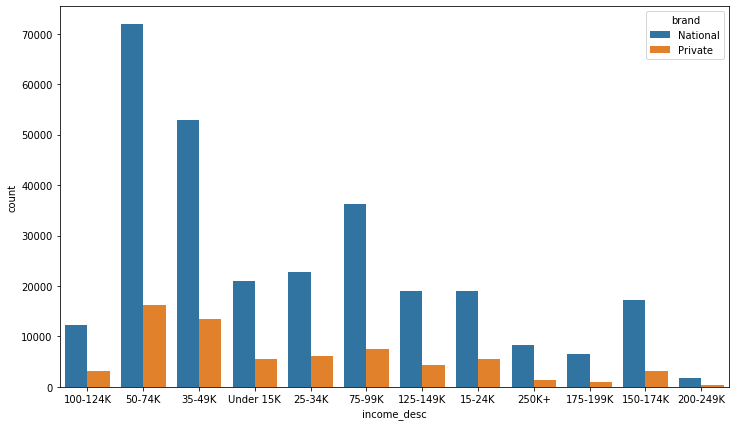

In [51]:
f, ax = plt.subplots(figsize=(12, 7))
sns.countplot(x='income_desc', hue='brand', data=data_train_with_features); 
plt.show()

In [52]:
brand_national = data_train_with_features[data_train_with_features['brand'] == 'National']
brand_data = brand_national.groupby('income_desc')['user_id'].count().reset_index()
brand_data.rename(columns={'user_id': 'national_brand'}, inplace=True)

In [53]:
brand_private = data_train_with_features[data_train_with_features['brand'] == 'Private']
brand_data_ = brand_private.groupby('income_desc')['user_id'].count().reset_index()
brand_data_.rename(columns={'user_id': 'private_brand'}, inplace=True)

In [54]:
brand_data = brand_data.merge(brand_data_, how='left', on='income_desc')
brand_data['percentage'] = brand_data['private_brand'] / (brand_data['private_brand'] + brand_data['national_brand']) * 100
brand_data

,income_desc,national_brand,private_brand,percentage
0,100-124K,12215,3098,20.231176
1,125-149K,18988,4283,18.404882
2,15-24K,19036,5548,22.567524
3,150-174K,17311,3186,15.543738
4,175-199K,6472,1019,13.602990
5,200-249K,1829,378,17.127322
6,25-34K,22693,6099,21.182967
7,250K+,8208,1361,14.223012
8,35-49K,52860,13539,20.390367
9,50-74K,71838,16200,18.401145


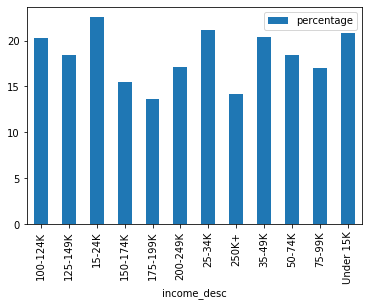

In [55]:
brand_data.plot(x ='income_desc', y='percentage', kind = 'bar')
plt.show()

Эта гистограмма показывает долю товаров торговой марки магазина от общего числа купленных товаров, в зависимости от дохода. Пользователи с высоким уровнем дохода, предположительно, покупают более дорогие и качественные бренды. Мы видим, что пользователи с высоким доходом действительно несколько реже покупают такие товары, по сравнению с теми пользователями, у которых доход низкий. Однако разница между этими группами оказалась не такой уж и существенной. Рользователям с высоким уровнем дохода тоже имеет смысл предлагать товары собственной торговой марки.

In [85]:
commodity_desc_data = data_train_with_features.groupby('commodity_desc')['item_id'].count().reset_index()
commodity_desc_data.rename(columns={'item_id': 'number'}, inplace=True)
commodity_desc_data = commodity_desc_data.sort_values('number', ascending=False).head(10)
commodity_desc_data

,commodity_desc,number
194,SOFT DRINKS,36349
17,BEEF,35399
91,FLUID MILK PRODUCTS,29348
49,COLD CEREAL,20127
37,CHEESE,18685
8,BAG SNACKS,18630
60,DELI MEATS,16537
98,FROZEN PIZZA,15757
103,FRZN MEAT/MEAT DINNERS,13512
130,LUNCHMEAT,13423


In [86]:
high_income = data_train_with_features[data_train_with_features['income_desc'] == '250K+']
high_income = high_income.groupby('commodity_desc')['item_id'].count().reset_index()
high_income.rename(columns={'item_id': 'high_income'}, inplace=True)
high_income = high_income.sort_values('high_income', ascending=False).head(10)
high_income

,commodity_desc,high_income
43,COLD CEREAL,440
76,FLUID MILK PRODUCTS,436
14,BEEF,316
33,CHEESE,259
152,SALAD MIX,257
35,CHICKEN,244
111,LUNCHMEAT,239
166,SOFT DRINKS,233
6,BAKED BREAD/BUNS/ROLLS,223
5,BAG SNACKS,208


In [87]:
low_income = data_train_with_features[data_train_with_features['income_desc'] == 'Under 15K']
low_income = low_income.groupby('commodity_desc')['item_id'].count().reset_index()
low_income.rename(columns={'item_id': 'low_income'}, inplace=True)
low_income = low_income.sort_values('low_income', ascending=False).head(10)
low_income

,commodity_desc,low_income
14,BEEF,1944
181,SOFT DRINKS,1727
82,FLUID MILK PRODUCTS,1105
89,FROZEN PIZZA,844
34,CHEESE,788
45,COLD CEREAL,703
6,BAG SNACKS,680
55,DELI MEATS,659
121,LUNCHMEAT,632
36,CHICKEN,617


In [88]:
commodity_desc_data = commodity_desc_data.merge(high_income, how='outer', on='commodity_desc')
commodity_desc_data = commodity_desc_data.merge(low_income, how='outer', on='commodity_desc')
commodity_desc_data

,commodity_desc,number,high_income,low_income
0,SOFT DRINKS,36349.0,233.0,1727.0
1,BEEF,35399.0,316.0,1944.0
2,FLUID MILK PRODUCTS,29348.0,436.0,1105.0
3,COLD CEREAL,20127.0,440.0,703.0
4,CHEESE,18685.0,259.0,788.0
5,BAG SNACKS,18630.0,208.0,680.0
6,DELI MEATS,16537.0,NaN,659.0
7,FROZEN PIZZA,15757.0,NaN,844.0
8,FRZN MEAT/MEAT DINNERS,13512.0,NaN,NaN
9,LUNCHMEAT,13423.0,239.0,632.0


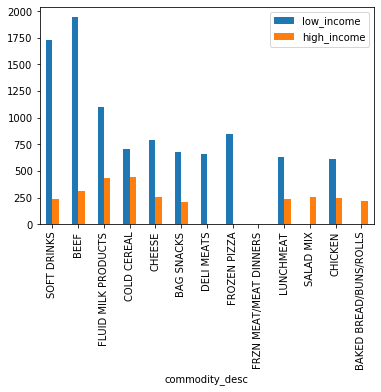

In [91]:
commodity_desc_data.plot(x ='commodity_desc', y=['low_income', 'high_income'], kind = 'bar')
plt.show()

На этой гистограмме видим различия между топ 10 категорий товаров для группы с самым высоким доходом и топ 10 категорий товаров для группы с самым низким доходом. Оказалось, что топ 10 категорий для обоих групп практически одинаковые (8 из 10 топ категорий совпадают)! Однако есть различия в ранжировании этих категорий по количеству покупок. В группе с высоким доходом на первых двух местах - хлопья и молоко. В группе с низким доходом - прохдадительные напитки и говядина.

### 3. LightFM

У этого алогритма есть множество параметров (item/user_alpha, loss, no_components).  
Проведите эксперименты аналогично дз 3 (подберите гипперпараметры каким удобно способои и постройте графики)  
На выходе необходимо получить pr@5 на валидации (последние 3 недели) > 17%  

У Вас, скорее всего, возникнет проблема со временем обучения. Почему они возникает?    

Попробуйте запустить алгоритм вообще без фичей или используйте только признаки с небольшим числом уникальных категорий. (item_features['commodity_desc'].unique() - 300 уникальных категорий - это очень много)

In [51]:
result = dict()
n=1

for no_components in [5, 10, 30]:
    for loss in ['bpr', 'warp']:
        for item_alpha in [0.001, 0.01, 0.1]:
            for user_alpha in [0.001, 0.01, 0.1]:
                
                model = LightFM(no_components=no_components,
                        loss=loss,
                        learning_rate=0.05, 
                        item_alpha=0.1, user_alpha=0.1, 
                        random_state=42)

                model.fit((sparse_user_item > 0) * 1,  # user-item matrix из 0 и 1
                          sample_weight=coo_matrix(user_item_matrix),
                          user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
                          item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
                          epochs=15, 
                          num_threads=4)

                train_precision = pr(model, sparse_user_item,
                                     user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
                                     item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
                                     k=5).mean()

                test_precision = pr(model, sparse_user_item_test,
                                    user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
                                    item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
                                    k=5).mean()

                result[n] = [no_components, loss, item_alpha, user_alpha, train_precision, test_precision]
                n+=1

In [52]:
result = pd.DataFrame.from_dict(result,orient='index',columns=['no_components', 'loss', 'item_alpha', 'user_alpha', 'train_precision', 'test_precision'])

In [53]:
result.sort_values(by='train_precision', ascending=False).head(10)

,no_components,loss,item_alpha,user_alpha,train_precision,test_precision
28,10,warp,0.001,0.001,0.294113,0.001806
46,30,warp,0.001,0.001,0.294113,0.001806
31,10,warp,0.010,0.001,0.294113,0.001806
32,10,warp,0.010,0.010,0.294113,0.001806
33,10,warp,0.010,0.100,0.294113,0.001806
34,10,warp,0.100,0.001,0.294113,0.001806
35,10,warp,0.100,0.010,0.294113,0.001806
36,10,warp,0.100,0.100,0.294113,0.001806
47,30,warp,0.001,0.010,0.294113,0.001806
29,10,warp,0.001,0.010,0.294113,0.001806


In [54]:
result.sort_values(by='test_precision', ascending=False).head(10)

,no_components,loss,item_alpha,user_alpha,train_precision,test_precision
27,10,bpr,0.100,0.100,0.208250,0.002709
26,10,bpr,0.100,0.010,0.208250,0.002709
20,10,bpr,0.001,0.010,0.208250,0.002709
21,10,bpr,0.001,0.100,0.208250,0.002709
22,10,bpr,0.010,0.001,0.208250,0.002709
23,10,bpr,0.010,0.010,0.208250,0.002709
24,10,bpr,0.010,0.100,0.208250,0.002709
25,10,bpr,0.100,0.001,0.208250,0.002709
19,10,bpr,0.001,0.001,0.208250,0.002709
37,30,bpr,0.001,0.001,0.211694,0.002609


Качество модели на тесте получилось плохим. Попробуем уменьшить количесво признаков товаров.

In [148]:
item_feat_lightfm.drop(columns = ['commodity_desc', 'sub_commodity_desc', 'curr_size_of_product'])
item_feat_lightfm = pd.get_dummies(item_feat, columns=item_feat.columns.tolist())

KeyError: "['commodity_desc' 'sub_commodity_desc' 'curr_size_of_product'] not found in axis"

In [ ]:
result = dict()
n=1

for no_components in [5, 10, 30]:
    for loss in ['bpr', 'warp']:
        for item_alpha in [0.001, 0.01, 0.1]:
            for user_alpha in [0.001, 0.01, 0.1]:
                
                model = LightFM(no_components=no_components,
                        loss=loss,
                        learning_rate=0.05, 
                        item_alpha=item_alpha, user_alpha=user_alpha, 
                        random_state=42)

                model.fit((sparse_user_item > 0) * 1,  # user-item matrix из 0 и 1
                          sample_weight=coo_matrix(user_item_matrix),
                          user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
                          item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
                          epochs=15, 
                          num_threads=4)

                train_precision = pr(model, sparse_user_item,
                                     user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
                                     item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
                                     k=5).mean()

                test_precision = pr(model, sparse_user_item_test,
                                    user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
                                    item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
                                    k=5).mean()

                result[n] = [no_components, loss, item_alpha, user_alpha, train_precision, test_precision]
                n+=1

### *Отбор признаков* * 

Все данные категориальные, при ohe кодировании для товаров признаков становится невероятно много.      
Какие стратегии отбора признаков в классическом ML Вы знаете? Применимы ли они тут?  

Попробйте какие-нибудь стратегии. Удалось ли улучшить качество?

 \* *задание необязательно*
